**ПЕРВИЧНАЯ ГИПОТЕЗА: Цены на недвижимость зависят в порядке убывания: характеристики самой квартиры (площадь общая, жилая, кухни, этаж, состояние, год постройки), местоположение (район, удление от центра, расстояние до метро и т.п.), наличие инфраструктуры (д/с, школы и т.д.) Влияние макроэкономических показателей малозначительно**

In [ ]:
!pip install -q catboost shap

     |████████████████████████████████| 76.1 MB 1.1 MB/s 
     |████████████████████████████████| 564 kB 44.8 MB/s 


In [ ]:
from catboost import CatBoostRegressor
from catboost import Pool, cv
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import os
import gc
import zipfile
from matplotlib import pyplot 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [ ]:
!wget -q --no-check-certificate \
    "https://github.com/kikos1978/ClassicML/files/7936988/All_data.zip" \
    -O "/tmp/All_data.zip"

zip_ref = zipfile.ZipFile('/tmp/All_data.zip', 'r') 
zip_ref.extractall('/tmp') 
zip_ref.close()

In [ ]:
macro = pd.read_csv('../tmp/macro.csv')
testDf = pd.read_csv('../tmp/test.csv')
fix = pd.read_excel('../tmp/BAD_ADDRESS_FIX.xlsx')
trainDf = pd.read_csv('../tmp/train.csv')

In [ ]:
print('Train shape: {} Rows, {} Columns'.format(*trainDf.shape))
print('Test shape: {} Rows, {} Columns'.format(*testDf.shape))

Train shape: 30471 Rows, 292 Columns
Test shape: 7662 Rows, 291 Columns


In [ ]:
#Пометим тренировочную и тестовые выборки и сольем датасет в один
testDf['isTrain'] = 0
trainDf['isTrain'] = 1
allDf = pd.concat([trainDf,testDf])
allDf.update(fix, filter_func = lambda x:np.array([True]*x.shape[0])) #Исправим ошибки из файла BAD_ADDRESS_FIX.xlsx

In [ ]:
#Прицепим датасет с макроэкономическими показателями
allDf = allDf.merge(macro, on='timestamp')
print('\nAll Data shape: {} Rows, {} Columns'.format(*allDf.shape))


All Data shape: 38133 Rows, 392 Columns


In [ ]:
#Чистим память, удаляя ненужные уже датасеты
del testDf, trainDf, macro, fix
gc.collect()

841

**Начнем Feature engineering**

In [ ]:
#Сконвертим timestamp  в DateTime
allDf['timestamp'] = pd.to_datetime(allDf['timestamp'])

In [ ]:
#Создадим новую категориальную фичу зависимость района + расстояние до метро
allDf['apartment_name'] = allDf.sub_area + allDf['metro_km_avto'].astype(str)
eco_map = {'excellent':4, 'good':3, 'satisfactory':2, 'poor':1, 'no data':0}
#А ещё одну превратим в числовую "руками"
allDf['ecology'] = allDf['ecology'].map(eco_map)

In [ ]:
#Отберем и закодируем категориальные признаки (в дальнейшем при использовании CatBoostRegressor - эту ячейку НЕ БУДЕМ ЗАПУСКАТЬ)
categorical_feature = [feature for feature in allDf.columns if allDf[feature].dtypes == "object"]
lbl = preprocessing.LabelEncoder()
for col in categorical_feature:
    allDf[col] = lbl.fit_transform(allDf[col].astype(str))

In [ ]:
#Зачистим выбросы (превратив их в NaN) типа гигантских или слишком маленьких площадей или явно ошибочные соотношения
allDf.loc[allDf.full_sq>2000,'full_sq'] = np.nan
allDf.loc[allDf.full_sq<3,'full_sq'] = np.nan
allDf.loc[allDf.life_sq>500,'life_sq'] = np.nan
allDf.loc[allDf.life_sq<3,'life_sq'] = np.nan
allDf.loc[allDf.life_sq>0.8*allDf.full_sq,'life_sq'] = np.nan
allDf.loc[allDf.kitch_sq>=allDf.life_sq,'kitch_sq'] = np.nan
allDf.loc[allDf.kitch_sq>500,'kitch_sq'] = np.nan
allDf.loc[allDf.kitch_sq<2,'kitch_sq'] = np.nan
#Тоже самое с явными ошибками в дата сете
allDf.loc[allDf.state>30,'state'] = np.nan
allDf.loc[allDf.build_year<1800,'build_year'] = np.nan
allDf.loc[allDf.build_year==20052009,'build_year'] = 2005
allDf.loc[allDf.build_year==4965,'build_year'] = np.nan
allDf.loc[allDf.build_year>2021,'build_year'] = np.nan
allDf.loc[allDf.num_room>15,'num_room'] = np.nan
allDf.loc[allDf.num_room==0,'num_room'] = np.nan
allDf.loc[allDf.floor==0,'floor'] = np.nan
allDf.loc[allDf.max_floor==0,'max_floor'] = np.nan
allDf.loc[allDf.floor>allDf.max_floor,'max_floor'] = np.nan
# Либо слишком высокие или слишком низкие цены за кв.м.
bad_index = allDf[allDf.price_doc/allDf.full_sq > 600000].index
bad_index = bad_index.append(allDf[allDf.price_doc/allDf.full_sq < 10000].index)
allDf.drop(bad_index,0,inplace=True)

In [ ]:
#Создадим теперь ещё и числовые признаки
allDf['year'] = allDf.timestamp.dt.year
#Отношение этажа к этажности здания
allDf['floor_by_max_floor'] = allDf.floor / allDf.max_floor

#Средний размер комнат, отношение жилой к общей, площади кухни к общей
allDf['avg_room_size'] = (allDf.life_sq - allDf.kitch_sq) / allDf.num_room
allDf['life_sq_prop'] = allDf.life_sq / allDf.full_sq
allDf['kitch_sq_prop'] = allDf.kitch_sq / allDf.full_sq

#Заменим год постройки на возраст дома
allDf['build_age'] = allDf.year - allDf.build_year
allDf = allDf.drop('build_year', 1)

#Плотность населения района, соотношение полов, число работающих ко всем
allDf['popu_den'] = allDf.raion_popul / allDf.area_m
allDf['gender_rate'] = allDf.male_f / allDf.female_f
allDf['working_rate'] = allDf.work_all / allDf.full_all

#Выбросим ситуации, когда нет мест в д/с, посчитаем критерий доступности мест в школе
allDf.loc[allDf.preschool_quota==0,'preschool_quota'] = np.nan
allDf['preschool_ratio'] =  allDf.children_preschool / allDf.preschool_quota
allDf['school_ratio'] = allDf.children_school / allDf.school_quota

## Квадратичные отклонения по площади и возрасту дома, произведение этажность на площадь и этаж на площадь
allDf['square_full_sq'] = (allDf.full_sq - allDf.full_sq.mean()) ** 2
allDf['square_build_age'] = (allDf.build_age - allDf.build_age.mean()) ** 2
allDf['full*maxfloor'] = allDf.max_floor * allDf.full_sq
allDf['full*floor'] = allDf.floor * allDf.full_sq
#Соотношение площади к возрасту (+0,5 для случая новосторек, где возраст  = 0)
allDf['full_to_age'] = allDf.full_sq / (allDf.build_age + 0.5)
#Произведение возраста на расстояние
allDf['age_to_state'] = allDf.build_age * allDf.state
#Разница расстояний до крупных магистралей
allDf['main_road_diff'] = allDf['big_road2_km'] - allDf['big_road1_km']

allDf.drop(['year','timestamp'], 1, inplace = True)

In [ ]:
#Это уже финально отобранные ниже признаки для конечного варианта, при первичном анализе не использовались
final_feat = ['price_doc', 'isTrain', 'full_sq', 'square_full_sq', 'life_sq', 'office_sqm_5000', 'cafe_count_5000_price_2500', 'num_room', 'cafe_count_3000_price_2500', 'cafe_count_2000', 'full*floor', 'cafe_count_5000_price_high', 'full*maxfloor', 'cafe_count_3000', 'cafe_count_2000_price_2500', 'ttk_km', 'build_age', 'kitch_sq', 'square_build_age', 'swim_pool_km', 'state', 'full_to_age', 'sport_count_3000', 'life_sq_prop', 'age_to_state', 'id', 'cafe_sum_5000_max_price_avg', 'cafe_count_5000_price_1500', 'hospital_beds_raion', 'theater_km', 'kindergarten_km', 'sadovoe_km']
allDf_final = allDf[final_feat]

In [ ]:
#Для удобства наименование датасета сделаем таким же
allDf_final = allDf.copy()

In [ ]:
#Посмотрим на корреляцию финальных фичей к цене
for col in allDf_final.columns:
  print(col, allDf_final['price_doc'].corr(allDf_final[col]))

In [ ]:
#Делим назад тренировачную и тестовую выборки и удалем timeStamp  и price_Doc
X = allDf_final[allDf_final.isTrain==1].drop(['isTrain'],1)
Y = X['price_doc']
X.drop(['price_doc'],1,inplace = True)
testDf_f = allDf_final[allDf_final.isTrain==0].drop(['isTrain','price_doc'],1)

In [ ]:
#Чистим память
del allDf, allDf_final
gc.collect()

144

**Инициализация и запуск моделей**

In [ ]:
#RMSE - для оценки
def rmse (y_true, y_pred):
  return round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)

In [ ]:
#CatBoostRegressor на сетке параметров
def run_catboost_GS(X_train, y_train, X_test):
  train_pool = Pool(data=X_train,
                    label=y_train
                    )
  model = cb.CatBoostRegressor(loss_function='RMSE')
  grid = {'iterations': [100, 150, 200, 300],
          'learning_rate': [0.03, 0.05, 0.1],
         'depth': [2, 4, 6, 8, 10],
          'l2_leaf_reg': [0.2, 0.5, 1, 3]}
  model.grid_search(grid, train_pool, cv=5)
  y_pred_train = model.predict(X_train)
  y_pred_submit = model.predict(X_test)

  print(f"CatB: RMSE train: {rmse(y_train, y_pred_train)}")
  return model, y_pred_submit

In [ ]:
%%time
# CatBoostRegressor на сетке параметров
cat_GS_model, cat_GS_preds = run_catboost_GS(X, Y, testDf_f)

In [ ]:
#Для остальных моделей разделим тренировочный датасет на тренировочный + валидационный
X_train,X_valid,y_train,y_valid = train_test_split(X,Y,test_size=0.2,random_state=50)

In [ ]:
#LightGBM
def run_lgb(X_train, y_train, X_val, y_val, X_test):
    
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgb_train_data = lgb.Dataset(X_train, label=y_train)
    lgb_val_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(params, lgb_train_data, 
                      num_boost_round=5000,
                      valid_sets=[lgb_train_data, lgb_val_data],
                      early_stopping_rounds=100,
                      verbose_eval=500)

    y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
    y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred_submit = model.predict(X_test, num_iteration=model.best_iteration)

    print(f"LGBM: RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    return y_pred_submit, model

In [ ]:
%%time
# LightGBM
lgb_preds, lgb_model = run_lgb(X_train, y_train, X_valid, y_valid, testDf_f)

**На этом этапе мы из модели LightGBM возьмём 30 "самых важных" признаков и уже на следующей итерации прогоним модели только на этих признаках**

In [ ]:
print("LightGBM features importance...")
gain = lgb_model.feature_importance('gain')
featureimp = pd.DataFrame({'feature': lgb_model.feature_name(), 
                   'split': lgb_model.feature_importance('split'), 
                   'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:30])

LightGBM features importance...
                         feature  split       gain
1                        full_sq   6971  29.701437
399               square_full_sq   2631   9.480991
2                        life_sq   3982   4.186610
280   cafe_count_5000_price_2500    442   3.414551
269              office_sqm_5000    397   3.210265
257   cafe_count_3000_price_2500    273   2.332038
6                       num_room    613   2.208172
226              cafe_count_2000    476   1.664249
402                full*maxfloor   2393   1.382747
234   cafe_count_2000_price_2500    248   1.291797
403                   full*floor   3077   1.283613
249              cafe_count_3000    309   1.146155
282   cafe_count_5000_price_high    264   0.974501
106                       ttk_km    653   0.931920
393                    build_age   1866   0.847169
400             square_build_age   1428   0.785695
130                 swim_pool_km    952   0.725013
264             sport_count_3000    418   0.679654

In [ ]:
#XGBoost
def run_xgb(X_train, y_train, X_val, y_val, X_test):
    params = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.001,
              'max_depth': 10,
              'subsample': 0.6,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 42,
              'silent': True}

    xgb_train_data = xgb.DMatrix(X_train, y_train)
    xgb_val_data = xgb.DMatrix(X_val, y_val)
    xgb_submit_data = xgb.DMatrix(X_test)

    model = xgb.train(params, xgb_train_data, 
                      num_boost_round=2000, 
                      evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
                      early_stopping_rounds=100, 
                      verbose_eval=500
                     )

    y_pred_train = model.predict(xgb_train_data, ntree_limit=model.best_ntree_limit)
    y_pred_val = model.predict(xgb_val_data, ntree_limit=model.best_ntree_limit)
    y_pred_submit = model.predict(xgb_submit_data, ntree_limit=model.best_ntree_limit)

    print(f"XGB : RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    return y_pred_submit, model

In [ ]:
#XGBoost
%%time
xgb_preds, xgb_model = run_xgb(X_train, y_train, X_valid, y_valid, testDf_f)

In [ ]:
#Catboost без сетки
def run_catboost(X_train, y_train, X_val, y_val, X_test):
                                 #eval_metric='RMSE',
    model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.05,
                             depth=10,
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True,
              verbose=True)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_submit = model.predict(X_test)

    print(f"CatB: RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    return y_pred_submit, model

In [ ]:
%%time
# Catboost без сетки
cat_preds, cat_model = run_catboost(X_train, y_train, X_valid, y_valid, testDf_f)

In [ ]:
#Сохранение результата
output = pd.read_csv('../tmp/test.csv')
output = output[['id']]
output['price_doc'] = cat_GS_preds
output.to_csv(r'Cat_gs.csv',index=False)
del output
output = pd.read_csv('../tmp/test.csv')
output = output[['id']]
output['price_doc'] = xgb_preds
output.to_csv(r'xgb_Sub.csv',index=False)
del output
output = pd.read_csv('../tmp/test.csv')
output = output[['id']]
output['price_doc'] = cat_preds
output.to_csv(r'cat_simple_Sub.csv',index=False)
del output
output = pd.read_csv('../tmp/test.csv')
output = output[['id']]
output['price_doc'] = lgb_preds
output.to_csv(r'lgb_Sub.csv',index=False)

**ВЫВОД: По признакам как и написано выше выбрали в итоге 30 самых "существенных" и они по всем моделям показали высокий результат и при этом модели, что естественно, обучались гараздо быстрее. Касаемо состава этих признаков, можно сказать что большая часть из них совпала с первичной гипотезой, в том числе отсутвие существенного влияния макроэкономических показателй, кроме признака среднего чека в ближайших кафе. Скорее всего этот показатель отражает степень "элитности" района местонахождения недвижимости.**

**Наилучший результат согласно персональной страничке на Kaggle показала модель "CatBoost на сетке парметров":**

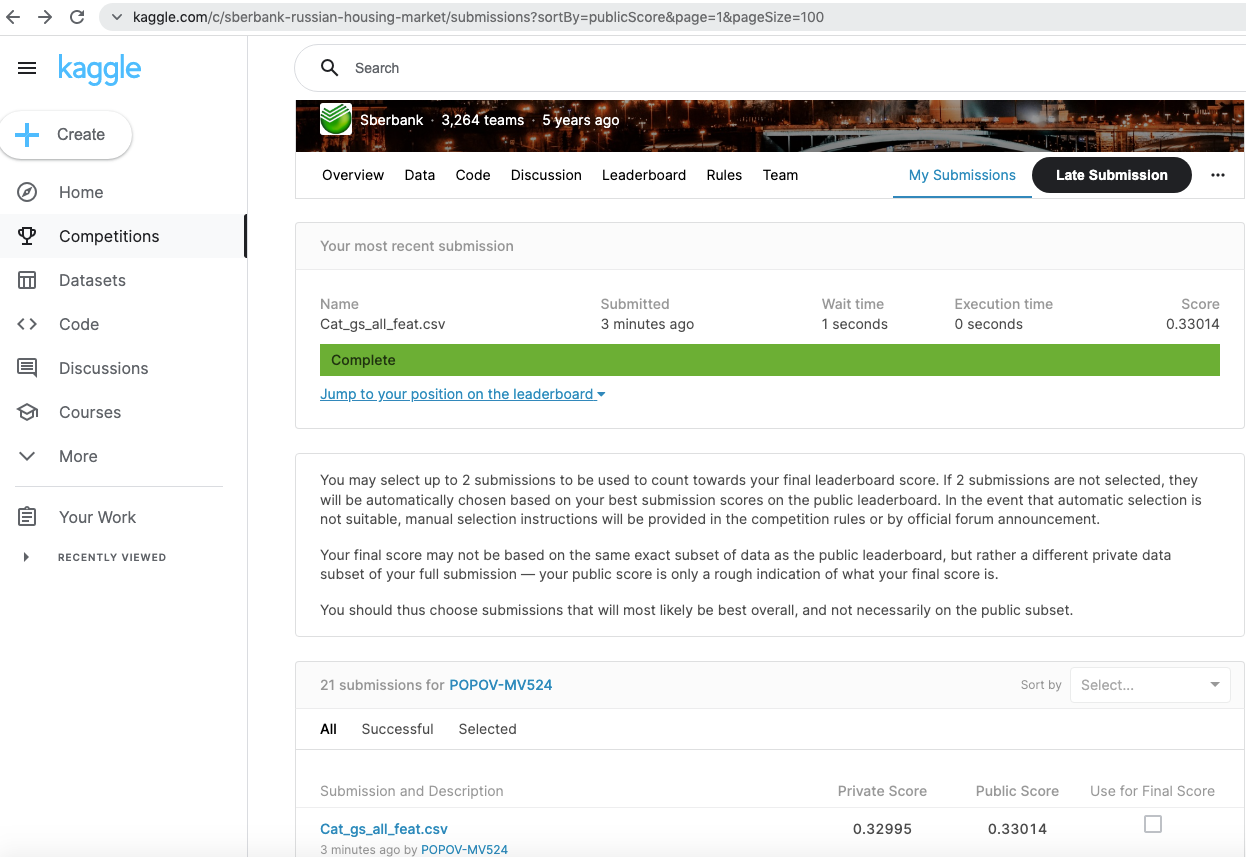